# Extracción de tópicos y representación vectorial de noticias

In [2]:
import psycopg2
import sys
import pandas as pd
import spacy
import gensim
import numpy as np
from gensim import corpora
from gensim import models
import pickle  # to save the dictionary
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [7]:
# --------------------------------------------------------------------------- #
# utility functions

# Función para ingesta desde base de datos
def get_news_data(dml_query,limit=100):

    con = psycopg2.connect("host='127.0.0.1' dbname='newspapers_oem1' \
    user='kenny' password='secr3tp455' port = 5433")   

    cur = con.cursor()
    #cur.execute("SELECT * FROM information_schema.sql_packages")
    #Select * from public.news_content1  WHERE newspaper_name = 'Periódico ABC' AND news_date_reported < '2018-01-01'
    #cur.execute("SELECT * FROM public.news_content1 WHERE section_name = 'opinion' AND importance_level = 'Nacional' AND newspaper_name = 'La Jornada' AND news_date_reported > '2018-11-10' LIMIT 160")
    
    # TEMPLATE QUERY !!!
    # cur.execute("SELECT * FROM public.news_content1 WHERE section_name = 'opinion' \
    # AND importance_level = 'Nacional' AND news_date_reported > '2018-11-10' LIMIT 250")
    
    dml_query=dml_query+" LIMIT "+str(limit)

    cur.execute(dml_query)
    
    ### Guardar en un dataframe pandas resultado de consulta

    col_names =  ['news_title', 'news_date_reported','section_name','news_content','news_link','newspaper_name','news_name_place_reported']
    my_df  = pd.DataFrame(columns = col_names)

    while True:

        row = cur.fetchone()

        if row == None:
            break
        my_df = my_df.append({'news_title': row[0], 'news_date_reported': row[1], 
                              'section_name': row[2],'news_content': row[3],
                              'news_link': row[4], 'newspaper_name':row[5], 'news_name_place_reported':row[6]}, ignore_index=True)


    con.close()
    
    return (my_df)


# Get lemas from a data.frame for each document
def get_lemma(df):
    
    lista_documentos = []
    for d in range(np.shape(df)[0]):

        doc = nlp(df.loc[d, 'news_content'])

        lda_tokens = [] # lista de tokens limpios

        for token in doc:
            
            # Validate the token (omit stopwords, punctuation, lowercase)
            temp_token = (token.lemma_).lower()
            if not(token.is_stop or token.is_punct or token.is_space):    
                lda_tokens.append(temp_token)

        lista_documentos.append(lda_tokens)
        
    return lista_documentos

In [32]:
# Query for Opinion

# dml_opinion = "SELECT * FROM public.news_content1 WHERE section_name = 'opinion' \
# AND importance_level = 'Nacional' AND news_date_reported > '2018-11-10' LIMIT 250"

dml_opinion = "SELECT DISTINCT news_title, news_date_reported, section_name, \
news_content, news_link, newspaper_name, news_name_place_reported FROM public.news_content1 \
WHERE section_name = 'policia' AND importance_level='local' AND news_date_reported > '2018-11-22'"

my_df = get_news_data(dml_opinion,limit=2500)  # save into a data frame

In [21]:
## Subsetear un data frame pandas
my_df.loc[1,'news_link']

'https://www.elsoldetampico.com.mx/policiaca/secuestran-y-asesinan-a-musicos-en-la-frontera-de-tamaulipas-2712711.html\n'

In [33]:
np.shape(my_df)

(1192, 7)

In [34]:
# nlp = spacy.load('es')
# doc = nlp(my_df.loc[3,'news_content'])


# lda_tokens = [] # lista de tokens limpios

# i = 0

# for token in doc:
#     #if token.pos_ =="VERB":
#     if not(token.is_stop or token.is_punct or token.is_space):
#         print(token.text, token.pos_,token.lemma_, token.dep_)
#         i += 1
#         lda_tokens.append(token.lemma_)

# print(i)

In [35]:
# for d in range(np.shape(my_df)[0]):
#     print(d)

In [36]:
nlp = spacy.load('es')  # spanish
nlp.vocab["a"].is_stop = True
nlp.vocab["y"].is_stop = True
nlp.vocab["El"].is_stop = True
nlp.vocab["La"].is_stop = True
nlp.vocab["en"].is_stop = True
nlp.vocab["En"].is_stop = True
nlp.vocab["o"].is_stop = True
nlp.vocab["O"].is_stop = True
# nlp.vocab[""].is_stop = True

In [37]:
lista_documentos = []
numero_noticias = np.shape(my_df)[0]

# Get lemmas skipping punctuation, spaces, and stop words

# for d in range(numero_noticias):

#     doc = nlp(my_df.loc[d, 'news_content'])

#     lda_tokens = [] # lista de tokens limpios

#     i = 0
#     for token in doc:
#         #if token.pos_ =="VERB":
        
#         temp_token = (token.lemma_).lower()
#         if not(token.is_stop or token.is_punct or token.is_space):
#             # print(token.text, token.pos_,token.lemma_, token.dep_)
#             i += 1
#             lda_tokens.append(temp_token)
#     lista_documentos.append(lda_tokens)


In [38]:
lista_documentos=[]
lista_documentos = get_lemma(my_df)

In [39]:
numero_noticias = np.shape(my_df)[0]

In [40]:
numero_noticias

1192

In [41]:
# --------------------------------------------------------------------------- #
# Build our dictionary
dictionary = corpora.Dictionary(lista_documentos)

# Check sparsity and other things
dictionary.filter_extremes(no_below = 5, no_above = 0.3)  # tunning dictionary

corpus = [dictionary.doc2bow(text) for text in lista_documentos]

# Save Corpus and Dictionary
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [42]:
# --------------------------------------------------------------------------- #
# LDA

# Note: The used parameters looks very good. Don't touch it!!!

NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                           id2word = dictionary, 
                                           passes=45, eval_every = None,
                                           iterations = 400, alpha = 0.40)
ldamodel.save('model1dicadrian.gensim')

topics = ldamodel.print_topics(num_words = 6)
for topic in topics:
    print(topic)

(0, '0.015*"unidad" + 0.013*"camioneta" + 0.013*"conductor" + 0.013*"lesionar" + 0.011*"accidentar" + 0.010*"trasladar"')
(1, '0.010*"seguridad" + 0.007*"casar" + 0.007*"solicitar" + 0.007*"mujer" + 0.007*"robar" + 0.006*"municipio"')
(2, '0.018*"armar" + 0.012*"callar" + 0.010*"fuego" + 0.008*"edad" + 0.008*"herir" + 0.008*"lesionar"')
(3, '0.011*"delito" + 0.011*"n" + 0.008*"público" + 0.008*"detener" + 0.007*"disposición" + 0.007*"agente"')
(4, '0.020*"cuerpo" + 0.010*"vida" + 0.009*"identificar" + 0.009*"investigación" + 0.008*"localizar" + 0.008*"autoridad"')


In [43]:
# --------------------------------------------------------------------------- #
# Get most probably topics for each document in the test set

num_docs = numero_noticias

array_topicos = np.zeros(num_docs)

for id_doc in range(num_docs):
    
    new_doc = lista_documentos[id_doc]  # En realidad esto deberia ser un test set
    new_doc_bow = dictionary.doc2bow(new_doc)  # create a Bag of Words
    most_prob_topic = ldamodel.get_document_topics(new_doc_bow)  # evaluate
    array_topicos[id_doc] = topics[most_prob_topic[0][0]][0]
    
    # print("noticia " + str(i))
    # print(topics[most_prob_topic[0][0]])
    # print(array_topicos[i])
    # print(most_prob_topic)


In [44]:
# Inspect the topics
print(array_topicos)
[[i,my_df.loc[i,'news_link']] for i in range(numero_noticias)]

[0. 0. 1. ... 0. 0. 1.]


[[0,
  'https://www.elheraldodetabasco.com.mx/policiaca/atropellado-por-varios-autos-en-huimanguillo-2735390.html\n'],
 [1,
  'https://www.elsoldesalamanca.com.mx/policiaca/muere-ciclista-atropellado-en-carretera-irapuato-salamanca-2709970.html\n'],
 [2,
  'https://www.elsoldehidalgo.com.mx/policiaca/fuerza-especial-detecta-a-hombres-con-drogas-2720664.html\n'],
 [3,
  'https://www.elsoldeirapuato.com.mx/policiaca/intensa-balacera-ocasiona-alarma-entre-habitantes-de-loma-de-flores-2706150.html\n'],
 [4,
  'https://www.elsoldetampico.com.mx/policiaca/secuestran-y-asesinan-a-musicos-en-la-frontera-de-tamaulipas-2712711.html\n'],
 [5,
  'https://www.noticiasdelsoldelalaguna.com.mx/policiaca/muere-presunto-agresor-en-balacera-2742318.html\n'],
 [6,
  'https://www.elsoldezacatecas.com.mx/policiaca/trailer-mata-a-peregrino-en-carretera-zacatecas-aguascalientes-2714259.html\n'],
 [7,
  'https://www.elsoldesanjuandelrio.com.mx/policiaca/asesinan-a-hombre-en-pleno-centro-de-san-juan-del-rio-274

In [20]:
# nlp = spacy.load('es') ### Cargar libreria para NER
# doc1 = nlp(my_df.loc[0,'news_content'])
# doc2 = nlp(my_df.loc[1,'news_content'])
# doc3 = nlp(my_df.loc[2,'news_content'])
# doc4 = nlp(my_df.loc[3,'news_content'])

# for ent in doc4.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [21]:
# print(doc1.similarity(doc2))
# print(doc1.similarity(doc3))
# print(doc1.similarity(doc4))

In [22]:
# nlp = spacy.load('es_core_news_md') ### Cargar libreria para NER
# doc = nlp(my_df.loc[0,'news_content'])

# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [23]:
# nlp = spacy.load('es_core_news_md') ### Cargar libreria para NER
# doc = nlp(my_df.loc[0,'news_content'])
# np.shape(doc.vector)


In [45]:
#obtener la clasificacion de topicos por cada noticia
#col_names =  ['news_date_reported','section_name','topic','frecuencia']
df_topicos = my_df.copy()
df_topicos["topico"] = np.zeros(np.shape(my_df)[0],dtype=int)

for id_doc in range(0,numero_noticias):
    new_doc = lista_documentos[id_doc]
    new_doc_bow = dictionary.doc2bow(new_doc)
    most_prob_topic=ldamodel.get_document_topics(new_doc_bow)
    df_topicos.loc[id_doc,"topico"] = most_prob_topic[0][0]
    #print(df_topicos.loc[i,"topico"])
    #print(my_df.loc[id_doc,'news_content'])


In [153]:
#df_topicos = my_df.copy()
#df_topicos["topico"] = np.zeros(np.shape(my_df)[0],dtype=int)

In [46]:
#df_topicos.loc[1:100,'topico']
print(df_topicos.iloc[1:5,0:6])

                                          news_title news_date_reported  \
1  Muere ciclista atropellado en carretera Irapua...         2018-11-24   
2       Fuerza Especial detecta a hombres con drogas         2018-11-27   
3  Intensa balacera ocasiona alarma\nentre habita...         2018-11-23   
4  Secuestran y asesinan a músicos en la frontera...         2018-11-25   

  section_name                                       news_content  \
1      policia  Un ciclista de aproximadamente 45 años murió l...   
2      policia  MINERAL DE LA REFORMA, Hgo.- Personal que conf...   
3      policia  Habitantes de la comunidad Loma de Flores vivi...   
4      policia  Río Bravo, Tamaulipas. – La noche de este sába...   

                                           news_link    newspaper_name  
1  https://www.elsoldesalamanca.com.mx/policiaca/...  elsoldesalamanca  
2  https://www.elsoldehidalgo.com.mx/policiaca/fu...    elsoldehidalgo  
3  https://www.elsoldeirapuato.com.mx/policiaca/i...   elso

In [47]:
#Convertir timestamp to fecha
## Agregar frecuencias por fecha
#pd.to_datetime(df_topicos.news_date_reported[0])
#dfST['timestamp'] = pd.to_datetime(dfST['timestamp'])
#df_topicos.news_date_reported = pd.to_datetime(df)
df_topicos['news_date_reported'] = df_topicos.news_date_reported.dt.date

In [48]:
# subsetear data frames condicionados a un cierto topico
df_topicos[df_topicos.topico ==0][1:10]

,news_title,news_date_reported,section_name,news_content,news_link,newspaper_name,news_name_place_reported,topico
1,Muere ciclista atropellado en carretera Irapua...,2018-11-24,policia,Un ciclista de aproximadamente 45 años murió l...,https://www.elsoldesalamanca.com.mx/policiaca/...,elsoldesalamanca,salamanca,0
3,Intensa balacera ocasiona alarma\nentre habita...,2018-11-23,policia,Habitantes de la comunidad Loma de Flores vivi...,https://www.elsoldeirapuato.com.mx/policiaca/i...,elsoldeirapuato,irapuato,0
4,Secuestran y asesinan a músicos en la frontera...,2018-11-25,policia,"Río Bravo, Tamaulipas. – La noche de este sába...",https://www.elsoldetampico.com.mx/policiaca/se...,elsoldetampico,río bravo,0
5,Muere presunto agresor en balacera,2018-12-01,policia,"Torreón, Coahuila.- En el ejido Rancho Alegre ...",https://www.noticiasdelsoldelalaguna.com.mx/po...,noticiasdelsoldelalaguna,torreón,0
6,Tráiler mata a peregrino en carretera Zacateca...,2018-11-25,policia,"Zacatecas, Zac.- Un zacatecano de 56 años de e...",https://www.elsoldezacatecas.com.mx/policiaca/...,elsoldezacatecas,zacatecas,0
7,Asesinan a hombre en pleno centro de San Juan ...,2018-12-01,policia,Un hombre fue asesinado a balazos esta madruga...,https://www.elsoldesanjuandelrio.com.mx/polici...,elsoldesanjuandelrio,san juan del rio,0
8,Secuestran a joven en Yautepec; ya fue liberado,2018-11-28,policia,"En menos de 48 horas, una víctima de secuestro...",https://www.elsoldecuautla.com.mx/policiaca/se...,elsoldecuautla,cuautla,0
9,Joven herido tras choque,2018-11-25,policia,Tremenda hemorragia se provocó joven conductor...,https://www.elsoldesanjuandelrio.com.mx/polici...,elsoldesanjuandelrio,san juan del rio,0
10,Roban dos camionetas en Edén y Nativitas,2018-11-30,policia,"En hechos distintos, dos camionetas fueron rob...",https://www.elsoldesalamanca.com.mx/policiaca/...,elsoldesalamanca,salamanca,0


In [28]:
df_topicos[df_topicos.topico ==1][1:10]

,news_title,news_date_reported,section_name,news_content,news_link,newspaper_name,news_name_place_reported,topico
4,Tráiler mata a peregrino en carretera Zacateca...,2018-11-25,policia,"Zacatecas, Zac.- Un zacatecano de 56 años de e...",https://www.elsoldezacatecas.com.mx/policiaca/...,elsoldezacatecas,zacatecas,1
8,Golpeado hasta morir,2018-11-30,policia,"Entre las calles Doria y Nicolás Bravo, en la ...",https://www.elsoldetulancingo.com.mx/policiaca...,elsoldetulancingo,tulancingo,1
13,Capturan a “El Estrellado”,2018-11-28,policia,"Inculpado en el homicidio de un hombre, ocurri...",https://www.elsoldeleon.com.mx/policiaca/captu...,elsoldeleon,leon,1
17,Trabajadores mueren aplastados tras derrumbe e...,2018-11-29,policia,"Uriel Saucedo, Tijuana.- Más de 6 horas les ll...",https://www.elsoldetijuana.com.mx/policiaca/tr...,elsoldetijuana,uriel saucedo,1
19,Rafaguean automóvil en Las Plazas; dos muertos...,2018-11-29,policia,Dos hombres fallecieron y dos mas resultaron l...,https://www.elsoldeirapuato.com.mx/policiaca/r...,elsoldeirapuato,irapuato,1
20,Vinculan a proceso a profesor de Milpillas,2018-11-23,policia,"La Fiscalía General del Estado (FIGE), a travé...",https://www.elsoldesanluis.com.mx/policiaca/vi...,elsoldesanluis,san luis potosi,1
23,Hombre se ahoga en casa de alcalde,2018-11-30,policia,Trágicamente concluyó la convivencia entre alc...,https://www.elsoldehidalgo.com.mx/policiaca/ho...,elsoldehidalgo,pachuca,1
25,Ejecutan a dos hombres en su vehículo en Abasolo,2018-11-25,policia,"ABASOLO, GTO.- Dos hombres que viajaban a bord...",https://www.elsoldeirapuato.com.mx/policiaca/e...,elsoldeirapuato,abasolo,1
26,Sobrevive pintor a descarga eléctrica,2018-11-24,policia,Un hombre identificado como Erick G. de 29 año...,https://www.elsoldetlaxcala.com.mx/policiaca/s...,elsoldetlaxcala,tlaxcala,1


In [49]:
df_topicos[df_topicos.topico ==2][1:10]

,news_title,news_date_reported,section_name,news_content,news_link,newspaper_name,news_name_place_reported,topico
17,Capturan a “El Estrellado”,2018-11-28,policia,"Inculpado en el homicidio de un hombre, ocurri...",https://www.elsoldeleon.com.mx/policiaca/captu...,elsoldeleon,leon,2
20,"Asesinan a ""El Chore"" en Barranca de Venaderos",2018-11-30,policia,"Tres sujetos en motocicleta, ejecutan al “Chor...",https://www.elsoldeleon.com.mx/policiaca/asesi...,elsoldeleon,leon,2
26,Vinculan a proceso a profesor de Milpillas,2018-11-23,policia,"La Fiscalía General del Estado (FIGE), a travé...",https://www.elsoldesanluis.com.mx/policiaca/vi...,elsoldesanluis,san luis potosi,2
28,Ladrón mata de una puñalada a comerciante tras...,2018-11-27,policia,"Una persona murió, tras ser asaltada y herida ...",https://www.diariodexalapa.com.mx/policiaca/la...,diariodexalapa,xalapa,2
74,Cae supuesto jefe delictivo,2018-11-27,policia,"Durante las primeras horas del día de ayer, fu...",https://www.elsoldelcentro.com.mx/policiaca/ca...,elsoldelcentro,aguascalientes,2
79,Cárcel a “El Leches”,2018-11-29,policia,"Alejandro Israel de 32 años alias “El Leches”,...",https://www.elsoldeleon.com.mx/policiaca/carce...,elsoldeleon,leon,2
99,Investigan posible vinculo de asesinatos\nen E...,2018-11-23,policia,Autoridades Ministeriales continúan investigan...,https://www.elsoldeirapuato.com.mx/policiaca/i...,elsoldeirapuato,irapuato,2
103,Capturan a asaltantes en motel,2018-11-28,policia,Tres hombres fueron detenidos al interior de u...,https://www.elsoldeleon.com.mx/policiaca/captu...,elsoldeleon,leon,2
105,Detienen a sujeto acusado de homicidio,2018-11-25,policia,Un sujeto que hace cinco meses presuntamente l...,https://www.elsoldesanluis.com.mx/policiaca/de...,elsoldesanluis,san luis potosi,2


In [30]:
df_topicos[df_topicos.topico ==3][1:10]

,news_title,news_date_reported,section_name,news_content,news_link,newspaper_name,news_name_place_reported,topico
112,Tres autos se impactan en la México-Pachuca,2018-11-30,policia,Tres autos de color rojo colisionaron entre sí...,https://www.elsoldehidalgo.com.mx/policiaca/tr...,elsoldehidalgo,pachuca,3
184,Decomisa CBP más de 2.7 millones en narcóticos,2018-11-29,policia,"Karina Torres, San Diego.- Elementos de aduana...",https://www.elsoldetijuana.com.mx/policiaca/de...,elsoldetijuana,karina torres,3
219,Detienen a policía cuando pretendía llevarse a...,2018-11-29,policia,"Xalapa, Ver.-En las instalaciones del Cuartel ...",https://www.elsoldecordoba.com.mx/policiaca/de...,elsoldecordoba,xalapa,3
220,[Video] Pobladores asaltan tren de carga: se r...,2018-11-27,policia,Puebla.- Un aproximado de 200 pobladores de es...,https://www.diariodexalapa.com.mx/policiaca/20...,diariodexalapa,xalapa,3
242,Militares repelen emboscada y detienen a uno,2018-11-24,policia,"NUEVA CIUDAD GUERRERO, Tamaulipas (OEM-Informe...",https://www.elsoldetampico.com.mx/policiaca/mi...,elsoldetampico,nueva ciudad guerrero,3
253,Choque por alcance de camión contra taxi,2018-11-28,policia,La bajada de pasajeros de un automóvil de alqu...,https://www.diariodequeretaro.com.mx/policiaca...,diariodequeretaro,queretaro,3
299,"Cientos paran tren, con leños encendidos y lla...",2018-11-28,policia,"Nazareno, Pue.- Un aproximado de 200 pobladore...",https://www.elsoldecordoba.com.mx/policiaca/ci...,elsoldecordoba,nazareno,3
347,Ingresan heridos en volcadura a hospital gener...,2018-11-27,policia,Córdoba. Ver.- Los lesionados por el choque de...,https://www.elsoldecordoba.com.mx/policiaca/in...,elsoldecordoba,cordoba,3
380,Averiguan 25 casos por delitos de hidrocarburo,2018-11-26,policia,El agente del Ministerio Público de la federac...,https://www.elsoldehidalgo.com.mx/policiaca/av...,elsoldehidalgo,pachuca,3


In [50]:
df_topicos[df_topicos.topico ==4][1:10]

,news_title,news_date_reported,section_name,news_content,news_link,newspaper_name,news_name_place_reported,topico
14,Encuentran ejecutado en camino a comunidad el ...,2018-11-27,policia,Un hombre ejecutado fue localizado en un camin...,https://www.elsoldesalamanca.com.mx/policiaca/...,elsoldesalamanca,salamanca,4
29,Encuentran cuerpo sin vida en camino a Llanitos,2018-11-23,policia,"JARAL DEL PROGRESO Con un balazo en el pecho, ...",https://www.elsoldesalamanca.com.mx/policiaca/...,elsoldesalamanca,salamanca,4
78,Encuentran el cadáver de un hombre en San Mate...,2018-11-24,policia,"San Mateo Atenco, México.- Con impacto de arma...",https://www.elsoldetoluca.com.mx/policiaca/enc...,elsoldetoluca,san mateo atenco,4
124,Localizan cuerpos dentro de bolsas de plástico...,2018-11-29,policia,Los cuerpos de dos personas desmembradas fuero...,https://www.elsoldeacapulco.com.mx/policiaca/l...,elsoldeacapulco,acapulco,4
232,Matan a hombre fuera del Cri-Cri,2018-11-26,policia,Un hombre hasta el momento no identificado fue...,https://www.lavozdelafrontera.com.mx/policiaca...,lavozdelafrontera,mexicali,4
247,"Abandonan a mujer ejecutada, le dejan mensaje ...",2018-11-29,policia,"Yanga, Ver.- Una mujer fue ejecutada y su cuer...",https://www.diariodexalapa.com.mx/policiaca/ab...,diariodexalapa,yanga,4
266,Hallan restos de un hombre en el campo,2018-11-26,policia,Los restos mortales de un hombre fueron hallad...,https://www.elsoldetlaxcala.com.mx/policiaca/h...,elsoldetlaxcala,tlaxcala,4
325,Sin identificar ejecutado en Cortázar,2018-11-28,policia,"CORTÁZAR, Gto. (OEM-Informex).- Continúa sin i...",https://www.elsoldelbajio.com.mx/policiaca/sin...,elsoldelbajio,cortázar,4
387,Hallan cadáver de hombre esposado en Apaseo El...,2018-11-30,policia,"APASEO EL GRANDE, Gto. (OEM-Informex).- Un hom...",https://www.diariodequeretaro.com.mx/policiaca...,diariodequeretaro,apaseo el grande,4


In [56]:
#df_topicos[df_topicos.topico ==1].group_by["news_date_reported"]
df_topicos["conteo"]=np.ones(np.shape(df_topicos)[0],dtype=int)
df_frecuencia_topicos = df_topicos.groupby(['topico','news_date_reported','newspaper_name'])[['conteo']].sum().reset_index()

# df_frecuencia_topicos.reset_index(level=0, inplace=True)
# df_frecuencia_topicos.reset_index(level=0, inplace=True)
# df_frecuencia_topicos.reset_index(level=0, inplace=True)

In [57]:
type(df_frecuencia_topicos)

pandas.core.frame.DataFrame

In [58]:
df_frecuencia_topicos

,topico,news_date_reported,newspaper_name,conteo
0,0,2018-11-23,diariodequeretaro,8
1,0,2018-11-23,diariodexalapa,7
2,0,2018-11-23,elheraldodechihuahua,6
3,0,2018-11-23,eloccidental,5
4,0,2018-11-23,elsoldecordoba,6
5,0,2018-11-23,elsoldecuautla,2
6,0,2018-11-23,elsoldecuernavaca,3
7,0,2018-11-23,elsoldehidalgo,2
8,0,2018-11-23,elsoldeirapuato,5
9,0,2018-11-23,elsoldelbajio,4


In [59]:
df_frecuencia_topicos[df_frecuencia_topicos.newspaper_name=='diariodequeretaro'].iloc[:,0:3]

,topico,news_date_reported,newspaper_name
0,0,2018-11-23,diariodequeretaro
21,0,2018-11-24,diariodequeretaro
43,0,2018-11-25,diariodequeretaro
64,0,2018-11-26,diariodequeretaro
85,0,2018-11-27,diariodequeretaro
109,0,2018-11-28,diariodequeretaro
135,0,2018-11-29,diariodequeretaro
164,0,2018-11-30,diariodequeretaro
193,0,2018-12-01,diariodequeretaro
233,1,2018-11-25,diariodequeretaro


In [60]:
df_topicos_paper = df_topicos.groupby(['topico','newspaper_name'])[['conteo']].sum().reset_index()
df_topicos_paper

,topico,newspaper_name,conteo
0,0,diariodequeretaro,46
1,0,diariodexalapa,52
2,0,elheraldodechiapas,13
3,0,elheraldodechihuahua,37
4,0,elheraldodetabasco,9
5,0,eloccidental,26
6,0,elsoldeacapulco,5
7,0,elsoldecordoba,49
8,0,elsoldecuautla,21
9,0,elsoldecuernavaca,27


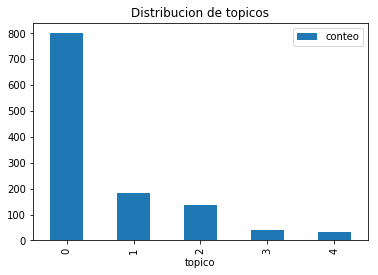

In [61]:
(df_topicos_paper.groupby(['topico'])[['conteo']].sum()).plot(kind='bar',title='Distribucion de topicos')


In [62]:
set(df_topicos_paper.newspaper_name.values)

{'diariodequeretaro',
 'diariodexalapa',
 'elheraldodechiapas',
 'elheraldodechihuahua',
 'elheraldodetabasco',
 'eloccidental',
 'elsoldeacapulco',
 'elsoldecordoba',
 'elsoldecuautla',
 'elsoldecuernavaca',
 'elsoldedurango',
 'elsoldehermosillo',
 'elsoldehidalgo',
 'elsoldeirapuato',
 'elsoldelbajio',
 'elsoldelcentro',
 'elsoldeleon',
 'elsoldeorizaba',
 'elsoldepuebla',
 'elsoldesalamanca',
 'elsoldesanjuandelrio',
 'elsoldesanluis',
 'elsoldetampico',
 'elsoldetijuana',
 'elsoldetlaxcala',
 'elsoldetoluca',
 'elsoldetulancingo',
 'elsoldezacatecas',
 'lavozdelafrontera',
 'noticiasdelsoldelalaguna'}

In [63]:
df_topicos_paper

,topico,newspaper_name,conteo
0,0,diariodequeretaro,46
1,0,diariodexalapa,52
2,0,elheraldodechiapas,13
3,0,elheraldodechihuahua,37
4,0,elheraldodetabasco,9
5,0,eloccidental,26
6,0,elsoldeacapulco,5
7,0,elsoldecordoba,49
8,0,elsoldecuautla,21
9,0,elsoldecuernavaca,27


/home/adrianrdzv/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


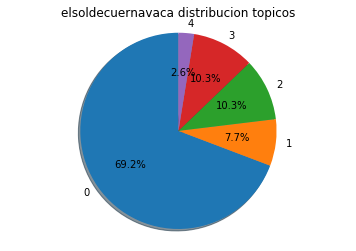

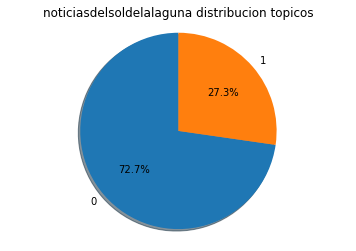

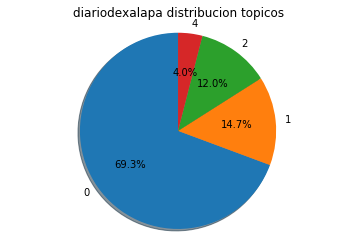

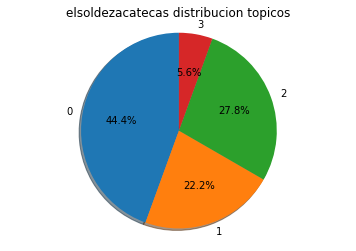

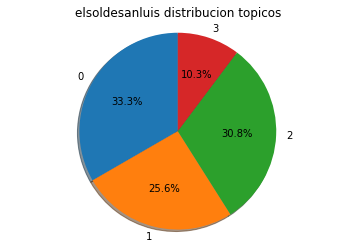

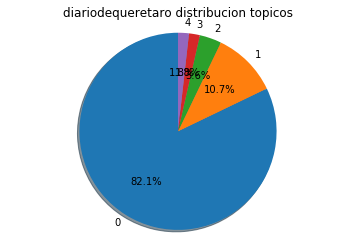

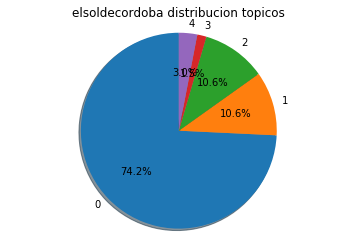

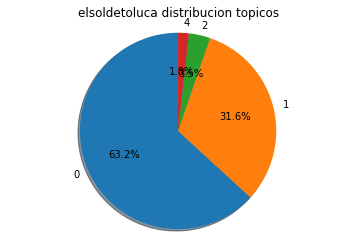

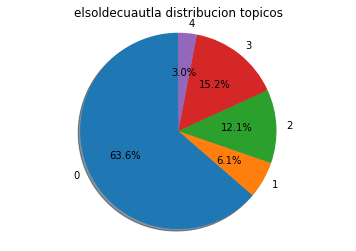

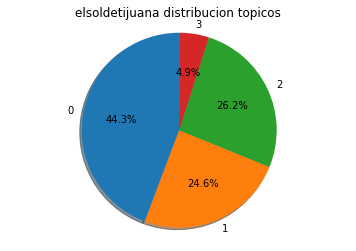

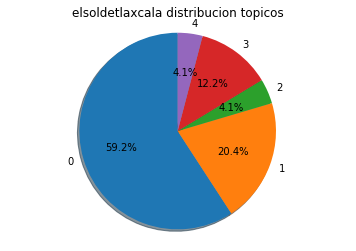

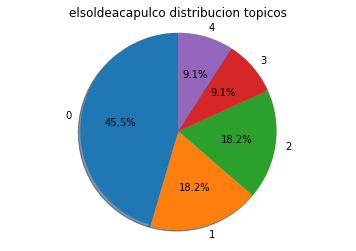

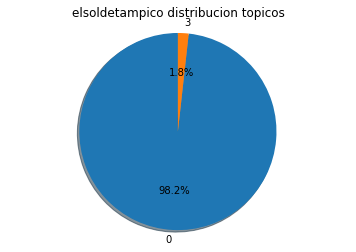

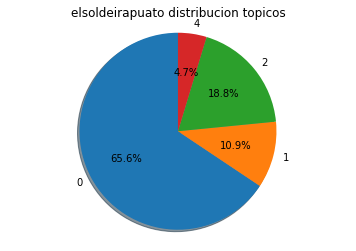

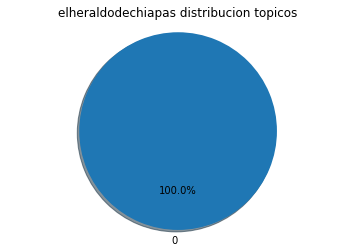

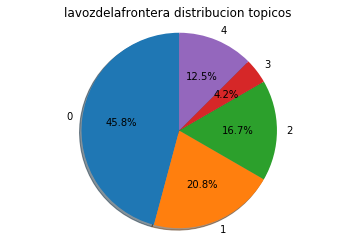

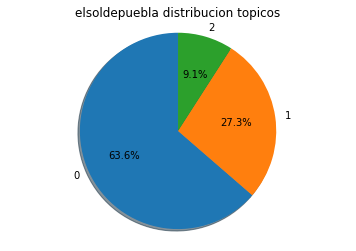

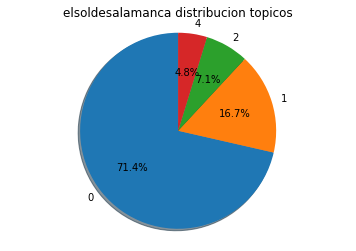

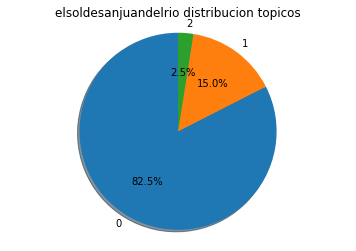

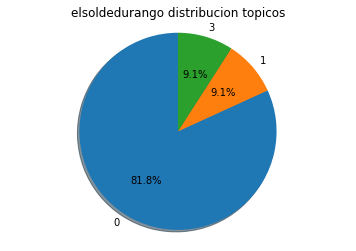

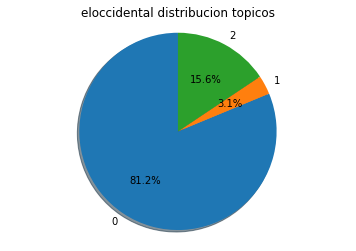

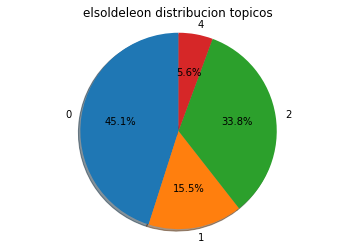

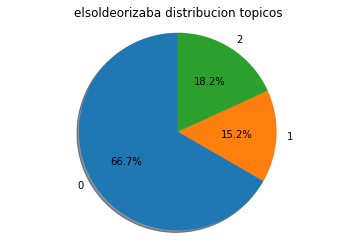

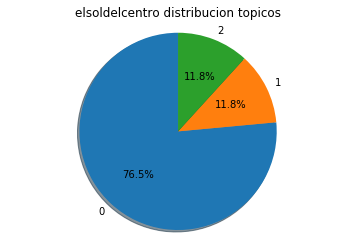

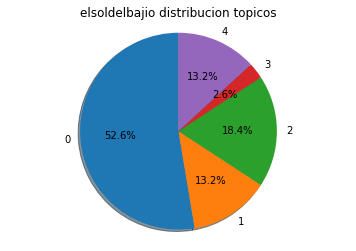

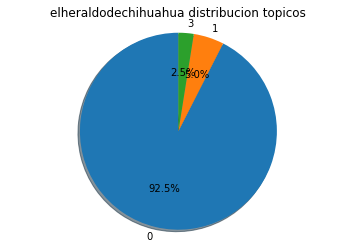

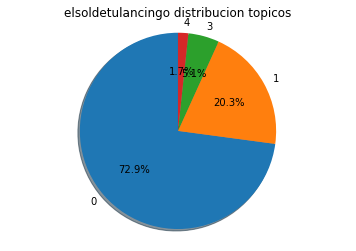

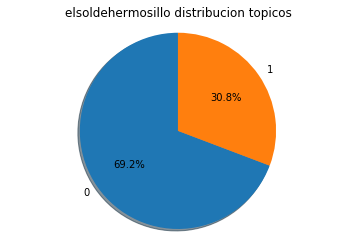

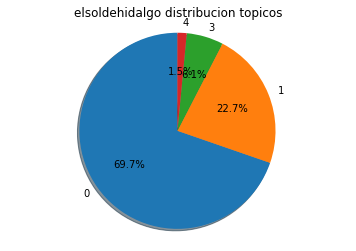

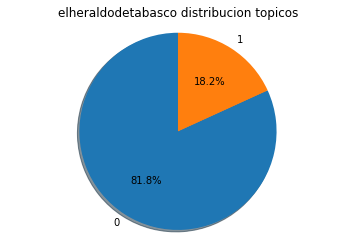

In [64]:
# Distribucion de topícos en cada periodicos

for periodico in set(df_topicos_paper.newspaper_name.values):

    labels = df_topicos_paper[df_topicos_paper.newspaper_name==periodico].topico
    sizes = df_topicos_paper[df_topicos_paper.newspaper_name==periodico].conteo

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90,)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(periodico+" distribucion topicos")

plt.show()

In [65]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus,ldamodel.id2word)


/home/adrianrdzv/anaconda3/envs/keras/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [66]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.093714 -0.026653       1        1  27.262159
0      0.184714 -0.106926       2        1  22.533531
4     -0.128326 -0.076211       3        1  19.356068
3      0.040493  0.186389       4        1  18.595398
1     -0.003168  0.023400       5        1  12.252841, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
61    Default  463.000000           cuerpo  463.000000  30.0000  30.0000
179   Default  571.000000            armar  571.000000  29.0000  29.0000
713   Default  212.000000           delito  212.000000  28.0000  28.0000
42    Default  249.000000       accidentar  249.000000  27.0000  27.0000
347   Default  350.000000        conductor  350.000000  26.0000  26.0000
737   Default  486.000000         lesionar  486.000000  25.0000  25.0000
449   Default  284.000000                n  284.000000  24.0000  24.0000
345   Default  134.000000          cadáver  134.000000  23.0000  23.0000
514   Default  160.000000       protección  160.000000  22.0000  22.0000
68    Default  121.000000          forense  121.000000  21.0000  21.0000
198   Default  334.000000            fuego  334.000000  20.0000  20.0000
39    Default  518.000000           unidad  518.000000  19.0000  19.0000
480   Default  190.000000            civil  190.000000  18.0000  18.0000
10    Default  266.000000            casar  266.000000  17.0000  17.0000
292   Default  374.000000             vida  374.000000  16.0000  16.0000
126   Default  159.000000      disposición  159.000000  15.0000  15.0000
477   Default  129.000000           chocar  129.000000  14.0000  14.0000
332   Default  227.000000            robar  227.000000  13.0000  13.0000
312   Default  294.000000            herir  294.000000  12.0000  12.0000
185   Default  445.000000        camioneta  445.000000  11.0000  11.0000
75    Default  350.000000    investigación  350.000000  10.0000  10.0000
273   Default  115.000000         procesar  115.000000   9.0000   9.0000
463   Default  382.000000        seguridad  382.000000   8.0000   8.0000
523   Default  116.000000         tránsito  116.000000   7.0000   7.0000
184   Default  453.000000           callar  453.000000   6.0000   6.0000
608   Default  127.000000         percance  127.000000   5.0000   5.0000
125   Default  223.000000          detener  223.000000   4.0000   4.0000
169   Default  215.000000           sujeto  215.000000   3.0000   3.0000
43    Default  108.000000        acordonar  108.000000   2.0000   2.0000
1176  Default  134.000000              mil  134.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
1932   Topic5   20.283848            video   28.127947   1.7725  -6.3181
463    Topic5  116.133728        seguridad  382.814148   0.9066  -4.5732
150    Topic5   55.766983        operativo  128.639420   1.2636  -5.3068
551    Topic5   64.159416           méxico  160.137878   1.1847  -5.1666
554    Topic5   56.664059         policial  136.028763   1.2237  -5.2908
332    Topic5   76.980568            robar  227.022705   1.0179  -4.9844
10     Topic5   84.313599            casar  266.991699   0.9467  -4.8934
1119   Topic5   78.188339            mujer  263.828888   0.8832  -4.9688
343    Topic5   53.242340         auxiliar  143.818024   1.1057  -5.3531
428    Topic5   54.044312        denunciar  149.198654   1.0839  -5.3382
299    Topic5   55.695000           apoyar  159.162186   1.0494  -5.3081
316    Topic5   60.583099        inmediato  191.811829   0.9469  -5.2239
130    Topic5   39.594776  fraccionamiento   91.900055   1.2574  -5.6493
362    Topic5   49.671810           número  143.445984   1.0389  -5.4225
17     Topic5   59.215290       domiciliar  229.216965   0.7459  -5.2468
1224   Topic5   37.174450         efectivo   89.811226   1.2173  -5.7123
36

In [67]:
num_words = 7
topics2 = ldamodel.print_topics(num_words = num_words)
for topic in topics2:
    print(topic)

(0, '0.015*"unidad" + 0.013*"camioneta" + 0.013*"conductor" + 0.013*"lesionar" + 0.011*"accidentar" + 0.010*"trasladar" + 0.008*"carretero"')
(1, '0.010*"seguridad" + 0.007*"casar" + 0.007*"solicitar" + 0.007*"mujer" + 0.007*"robar" + 0.006*"municipio" + 0.006*"méxico"')
(2, '0.018*"armar" + 0.012*"callar" + 0.010*"fuego" + 0.008*"edad" + 0.008*"herir" + 0.008*"lesionar" + 0.007*"llegar"')
(3, '0.011*"delito" + 0.011*"n" + 0.008*"público" + 0.008*"detener" + 0.007*"disposición" + 0.007*"agente" + 0.006*"investigación"')
(4, '0.020*"cuerpo" + 0.010*"vida" + 0.009*"identificar" + 0.009*"investigación" + 0.008*"localizar" + 0.008*"autoridad" + 0.007*"personal"')


In [68]:
!pwd

/home/adrianrdzv/MEGAsync/prdc/paso


In [72]:
from lugarNoticia import lugarDefault
df_frecuencia_topicos["newspaper_name"] = pd.Series([lugarDefault(periodico) for periodico in df_frecuencia_topicos.newspaper_name])
df_frecuencia_topicos

,topico,news_date_reported,newspaper_name,conteo
0,0,2018-11-23,Queretaro,8
1,0,2018-11-23,Xalapa,7
2,0,2018-11-23,Chihuahua,6
3,0,2018-11-23,Guadalajara,5
4,0,2018-11-23,Cordoba,6
5,0,2018-11-23,Cuautla,2
6,0,2018-11-23,Cuernavaca,3
7,0,2018-11-23,Pachuca,2
8,0,2018-11-23,Irapuato,5
9,0,2018-11-23,Guanajuato,4


In [73]:
df_frecuencia_topicos.to_csv("df_topicos_frecuencia_policiaca.csv",index=False)

In [74]:
!head df_topicos_frecuencia_policiaca.csv

topico,news_date_reported,newspaper_name,conteo
0,2018-11-23,Queretaro,8
0,2018-11-23,Xalapa,7
0,2018-11-23,Chihuahua,6
0,2018-11-23,Guadalajara,5
0,2018-11-23,Cordoba,6
0,2018-11-23,Cuautla,2
0,2018-11-23,Cuernavaca,3
0,2018-11-23,Pachuca,2
0,2018-11-23,Irapuato,5


In [75]:
#!ls | grep py
!head lugarNoticia.py

def lugarDefault(string):   #Funcion para arreglar el formato de la fecha
    lugares_default = {
        'elsoldeirapuato': "Irapuato",
        'elsoldelbajio': "Guanajuato",
        'elsoldeleon': "Leon",
        'elsoldehidalgo': "Pachuca",
        'diariodequeretaro': "Queretaro",
        'elsoldesalamanca': "Salamanca",
        'elsoldesanjuandelrio': "San Juan del Rio",
        'diariodexalapa': "Xalapa",


In [76]:
pd.read_csv("df_topicos_frecuencia_policiaca.csv")

,topico,news_date_reported,newspaper_name,conteo
0,0,2018-11-23,Queretaro,8
1,0,2018-11-23,Xalapa,7
2,0,2018-11-23,Chihuahua,6
3,0,2018-11-23,Guadalajara,5
4,0,2018-11-23,Cordoba,6
5,0,2018-11-23,Cuautla,2
6,0,2018-11-23,Cuernavaca,3
7,0,2018-11-23,Pachuca,2
8,0,2018-11-23,Irapuato,5
9,0,2018-11-23,Guanajuato,4
